In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from tsai.basics import timer
from tsai.models.MINIROCKET import MiniRocketRegressor

In [2]:
warnings.filterwarnings(action='ignore', category=UserWarning)

df = pd.read_excel('./DATASET.xlsx')
df.rename(columns={'Unnamed: 0':'Section'}, inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Section  101 non-null    object 
 1   year     1009 non-null   int64  
 2   Para-1   1009 non-null   float64
 3   Para-2   1009 non-null   float64
 4   Para-3   1009 non-null   float64
 5   Para-4   1009 non-null   float64
 6   Para-5   1009 non-null   int64  
 7   Para-6   1009 non-null   int64  
 8   Para-7   1009 non-null   int64  
 9   Para-8   1009 non-null   int64  
 10  Para-9   1009 non-null   float64
 11  Para-10  1009 non-null   float64
 12  Para-11  1009 non-null   float64
 13  Para-12  1009 non-null   int64  
 14  Para-13  1007 non-null   float64
dtypes: float64(8), int64(6), object(1)
memory usage: 118.4+ KB
None


In [3]:
def check_null(df):
    null_entries = df.loc[:,'year':].isnull().any()
    return df.loc[:,'year':].columns[null_entries].tolist()

In [4]:
def get_selected_parameters(x, y, parameters=[8, 9, 10, 11, 12]):
    new_x, new_y = [], []
    for x_vals in x:
        new_x.append(x_vals[parameters])
    for y_vals in y:
        new_y.append(y_vals[parameters])
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    if new_y.dtype == 'object':
        new_y = new_y.astype('float64')
    return new_x, new_y 
    

In [5]:
null_colmns = check_null(df)
print(f'Null Columns: {null_colmns}')
if len(null_colmns)>0:
    print('Filling Null Values')
    [df[col].fillna(method='bfill',inplace=True) for col in null_colmns]

Null Columns: ['Para-13']
Filling Null Values


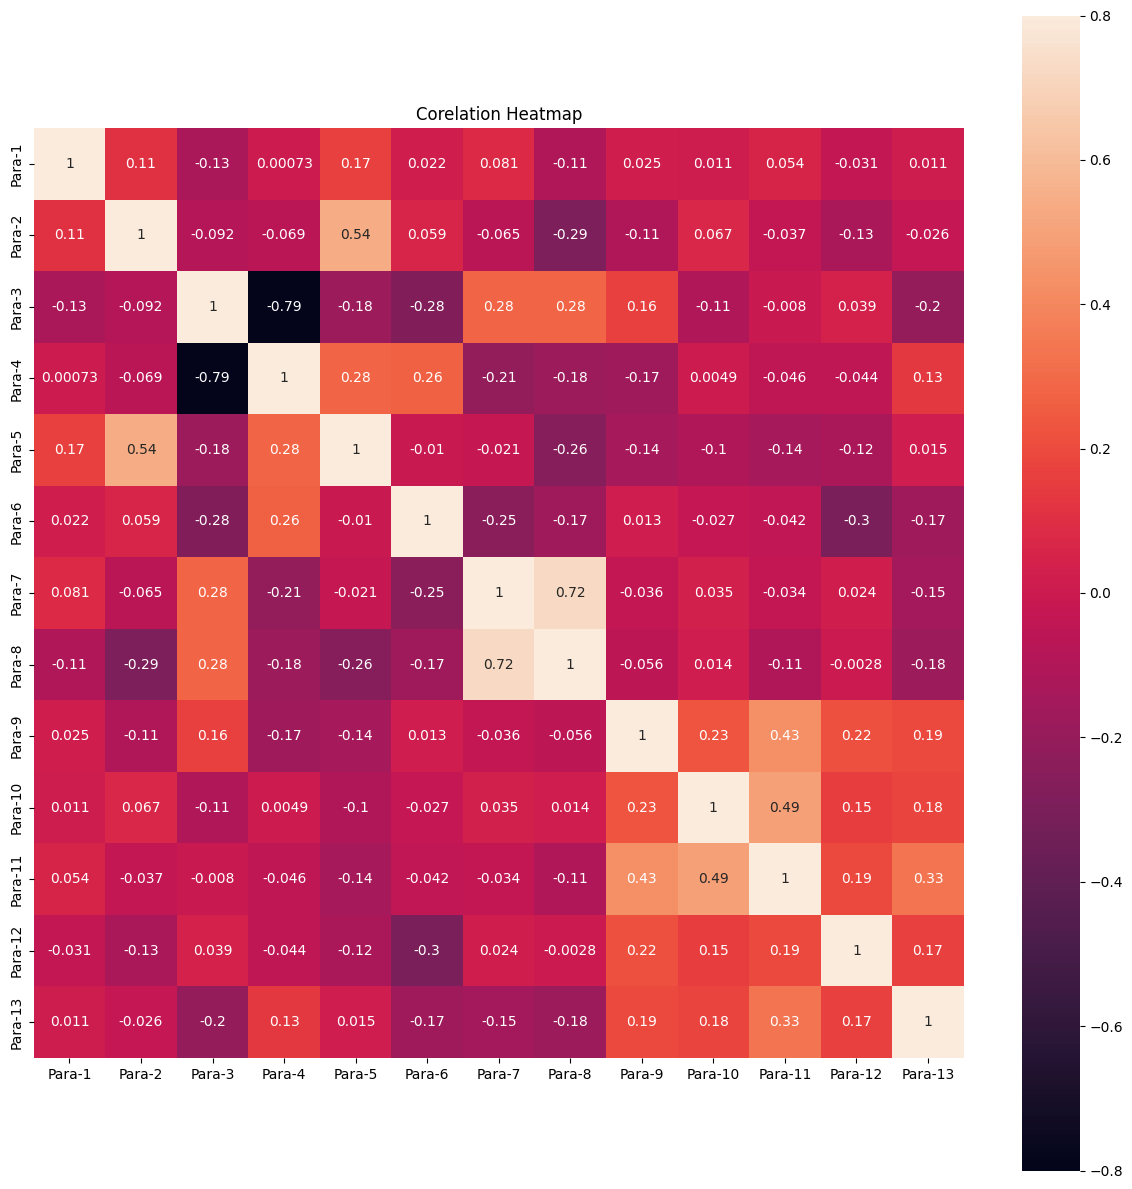

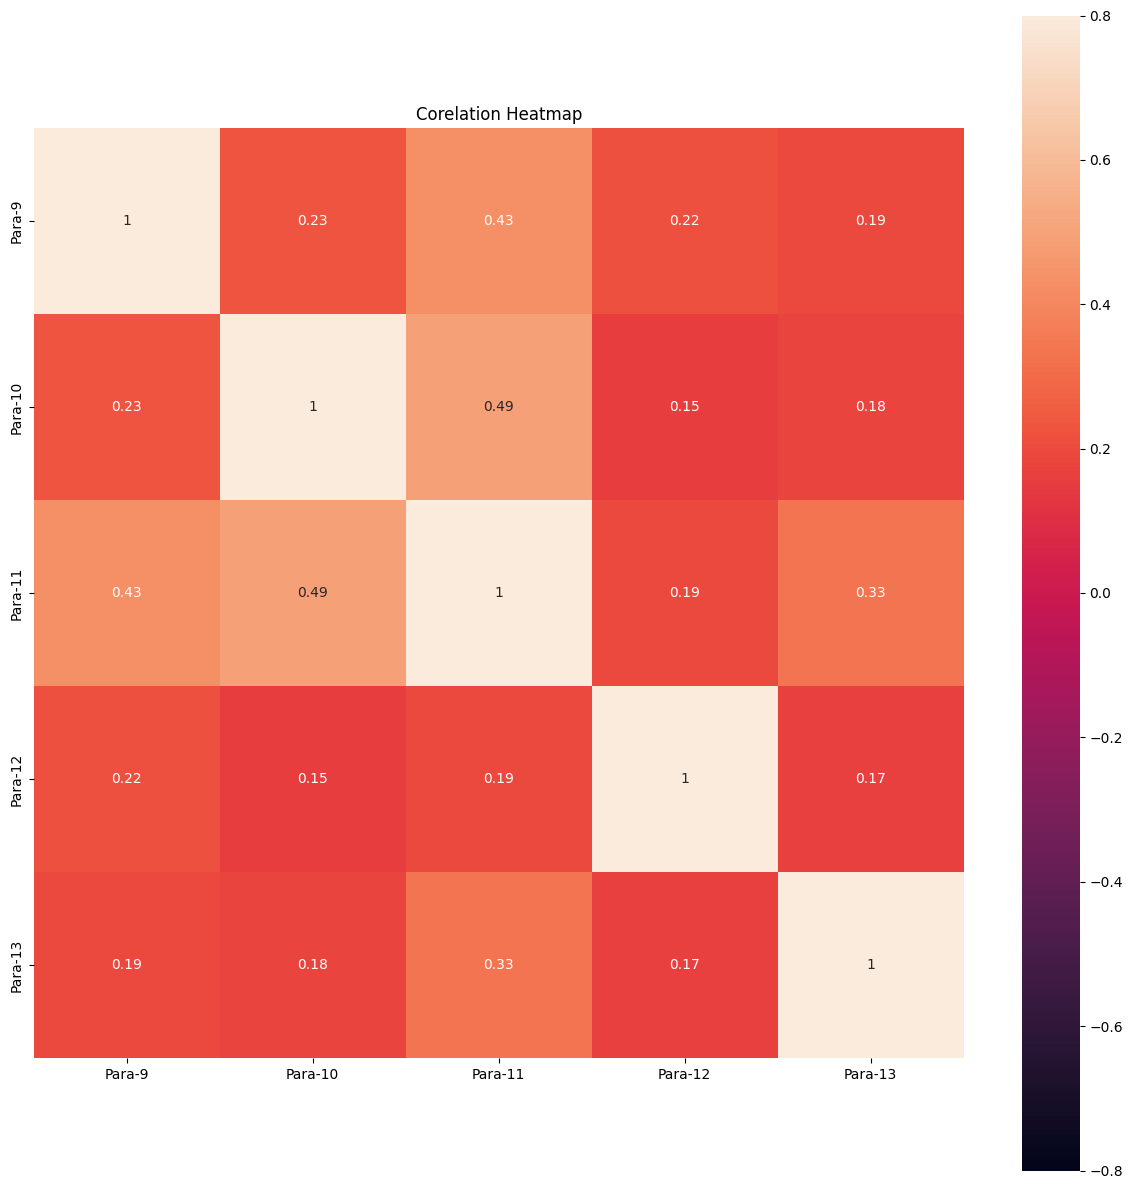

In [6]:
C_mat = df.loc[:,'Para-1':].corr()
fig = plt.figure(figsize = (15,15))
plt.title('Corelation Heatmap')
sns.heatmap(C_mat, vmax = 0.8, vmin = -0.8,  square = True, annot=True)
plt.show()
C_mat = df.loc[:,'Para-9':].corr()
fig = plt.figure(figsize = (15,15))
plt.title('Corelation Heatmap')
sns.heatmap(C_mat, vmax = 0.8, vmin = -0.8,  square = True, annot=True)
plt.show()

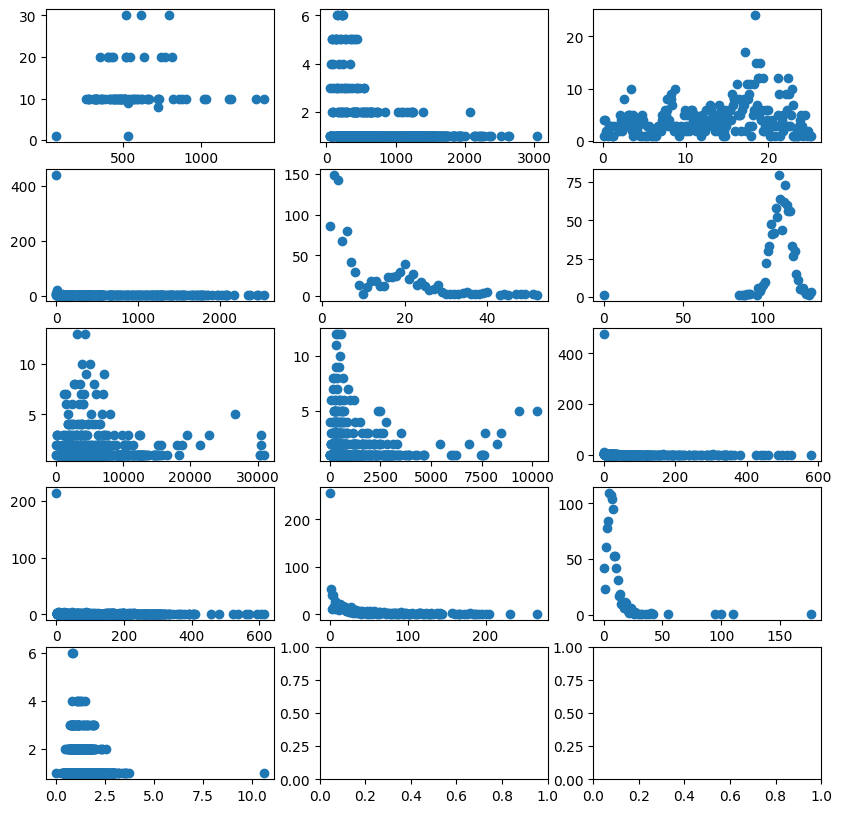

In [7]:
fig, axs = plt.subplots(5, 3, figsize=(10,10))
x, y = 0,-1
for i in range(13):
    x = i//3
    y = i%3
    col = df.columns[i+2]
    axs[x,y].scatter(df[col].value_counts().index, df[col].value_counts())

In [8]:
print('Scaling attributes')
scalar = {}
for column in df.columns[2:]:
    scalar[column] = MinMaxScaler()
    df[column] = scalar[column].fit_transform(df[column].values.reshape(-1,1))
print('Scaling objects for all columns are saved for inverse transformations')

Scaling attributes
Scaling objects for all columns are saved for inverse transformations


In [9]:
df['Section'].ffill(inplace=True)
df_sections = df.groupby('Section', dropna=False)

print(f'Grouped dataframe by sections\nDataFrame Size: {len(df)}\nGroups: {len(df_sections)}')

Grouped dataframe by sections
DataFrame Size: 1009
Groups: 101


In [10]:
print('Converting Dataframe to 3d structure of shape:\n1. Samples\n2. Variables\n3. Length')
x_raw, y_raw = [], []
i=0
for section in list(df_sections):
    section[1].reset_index(inplace=True)
    # print(section[1].loc[:8,'Para-1':'Para-7'].T)
    if len(section[1]) == 10:
        x_raw.append(section[1].loc[:8,'Para-1':'Para-13'].T)
        y_raw.append(section[1].loc[9,'Para-1':'Para-13'].T)
x_raw = np.array(x_raw)
y_raw = np.array(y_raw)
if y_raw.dtype == 'object':
    y_raw = y_raw.astype('float64')
print(f'New Shape:\nX: {x_raw.shape}\nY: {y_raw.shape}')

Converting Dataframe to 3d structure of shape:
1. Samples
2. Variables
3. Length
New Shape:
X: (100, 13, 9)
Y: (100, 13)


> Note: Sections with data missing for a complete year are dropped in 2D to 3D conversion

In [11]:
x, y = get_selected_parameters(x_raw, y_raw)
test_size = 0.15
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
print(f'Train and Test split\nTest Size: {test_size}')

Train and Test split
Test Size: 0.15


In [12]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = MiniRocketRegressor(scoring=rmse_scorer)
timer.start(False)
model.fit(x_train, y_train)
t = timer.stop()
print(f'Model Trained\nTime: {t}')
y_pred = model.predict(x_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
model.save(f'MRVRegressor_{r2:.10f}')
print('Model saved')

Model Trained
Time: 0:00:00.089835
Model saved


In [13]:
print(f'Model scoring\nRMSE : {rmse:.5f}\nR2 : {r2:.5f}')

Model scoring
RMSE : 0.07689
R2 : 0.74441


In [37]:
y_raw_pred = model.predict(x)
r2_total = r2_score(y, y_raw_pred)
rmse_total = mean_squared_error(y, y_raw_pred, squared=False)
print(f'Overall score for all values\nR2 :{r2_total:0.5f}\nRMSE :{rmse_total:0.5f}')

Overall score for all values
R2 :0.96000
RMSE :0.03320


In [36]:
parameters = ['Para-9','Para-10','Para-11','Para-12','Para-13']
predicted_df = pd.DataFrame()
for i in range(y_pred.shape[1]):
    temp = np.round(scalar[parameters[i]].inverse_transform(y_test[:,i].reshape(-1,1)), decimals= 1)
    predicted_df[parameters[i]] = temp.tolist()
    temp = np.round(scalar[parameters[i]].inverse_transform(y_pred[:,i].reshape(-1,1)), decimals= 1)
    predicted_df[parameters[i]+'_P'] = temp.tolist()
print(predicted_df)

     Para-9 Para-9_P  Para-10 Para-10_P  Para-11 Para-11_P Para-12 Para-12_P  \
0     [6.0]   [-0.9]   [76.9]    [71.9]   [27.0]    [29.2]  [11.0]    [10.9]   
1   [169.5]  [129.0]   [44.4]    [69.9]   [56.0]    [63.2]  [25.0]    [21.4]   
2   [167.4]  [192.9]  [166.4]   [243.9]  [195.0]   [137.8]   [6.0]     [2.4]   
3   [498.4]  [297.9]  [295.6]   [321.9]  [201.0]   [163.3]  [14.0]    [10.1]   
4   [447.5]  [199.5]  [299.1]   [344.2]  [111.0]    [93.3]  [10.0]     [6.3]   
5   [158.6]  [109.0]  [120.6]   [133.0]   [52.0]    [66.4]  [10.0]     [8.5]   
6     [0.0]   [10.5]   [83.5]    [75.3]    [6.0]     [7.9]   [7.0]     [2.5]   
7     [1.0]   [38.5]    [2.0]   [-10.7]    [2.0]     [6.6]   [1.0]    [-6.1]   
8    [25.6]   [66.2]  [288.3]   [346.5]   [50.0]    [32.3]   [3.0]     [7.1]   
9    [16.8]   [19.6]  [105.0]    [90.9]   [65.0]    [76.3]   [9.0]    [10.9]   
10   [74.5]   [83.5]   [58.2]    [77.3]  [266.4]   [182.9]  [14.0]    [17.7]   
11   [67.1]  [118.3]  [391.1]   [307.3] 